In [4]:
"""
    Reproduce Figure 1.
"""

import os
import argparse
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from rich import print as rprint

from dkps.embed import embed_api, _aembed_api
from dkps import DataKernelPerspectiveSpace

import numpy as np
from scipy.spatial.distance import pdist, squareform

def make_embedding_dict(df):
    model_names  = df.model.unique()
    instance_ids = df.instance_id.unique()
    
    embedding_dict = {}
    for model_name in model_names:
        sub = df[df.model == model_name]
        assert (sub.instance_id.values == instance_ids).all(), f'instance_ids are not the same for model {model_name}'
        embedding_dict[model_name] = np.vstack(sub.embedding.values)
    
    embedding_dict = {k:v[:,None] for k,v in embedding_dict.items()}
    
    return embedding_dict


def dkps_df(df, **kwargs):
    embedding_dict = make_embedding_dict(df)
    return DataKernelPerspectiveSpace(**kwargs).fit_transform(embedding_dict, return_dict=True)

In [5]:
np.random.seed(0)
dataset = 'math'
subtask = 'math:subject=counting_and_probability'
score_col = 'score'
outdir = '/home/paperspace/projects/dkps/examples/helm/data/'
tsv_path = Path(outdir) / f'{dataset}.tsv'

sample=0


rprint('[blue]loading data ...[/blue]')

df = pd.read_csv(tsv_path, sep='\t')
print(len(df))
df = df[df.dataset == subtask]
print(len(df))

if sample:
    rng           = np.random.default_rng(seed)
    uinstance_ids = df.instance_id.unique()
    keep          = rng.choice(uinstance_ids, int(len(uinstance_ids) * sample), replace=False)
    df            = df[df.instance_id.isin(keep)]

df = df.sort_values(['model', 'instance_id']).reset_index(drop=True)

if score_col != 'score':
    print(f'{score_col} -> score')
    df['score'] = df[score_col]


model2score = df.groupby('model').score.mean().to_dict()

# --
# QC

print(f'{len(df.response.unique())} / {df.shape[0]} responses are unique')
instance_ids = df.groupby('model').instance_id.apply(list)
assert all([instance_ids.iloc[0] == instance_ids.iloc[i] for i in range(len(instance_ids))]), 'instance_ids are not the same for each model'

# --
# Get embeddings


embeddings = await _aembed_api(
    provider   = 'google', 
    input_strs = [str(xx) for xx in df.response.values],
    model      = None
)
df['embedding'] = list(embeddings)

model2score = df.groupby('model').score.mean().to_dict()

uinstance_ids = np.random.choice(df.instance_id.unique(), size=min(50, len(df.instance_id.unique())), replace=False)
umodels       = np.random.permutation(df.model.unique())

loading data ...

41515
3705
3537 / 3705 responses are unique


Embedding chunks: 100%|████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 759.11it/s]


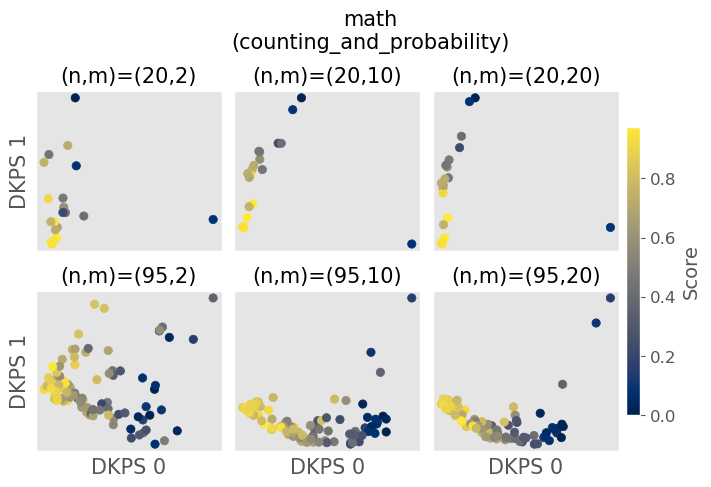

In [13]:
np.random.seed(1)

fig, axes = plt.subplots(2, 3, figsize=(7.5, 5))
plt.style.use('ggplot')

Ps = {}
for c, n_instances in enumerate([2, 10, 20]):
    _instance_ids = uinstance_ids[:n_instances]
    for r, n_models in enumerate([20, len(umodels)]):
        _models      = umodels[:n_models]
        _model2score = {m:model2score[m] for m in _models}
        
        df_sub = df[df.instance_id.isin(_instance_ids)]
        df_sub = df_sub[df_sub.model.isin(_models)]
        P_sub  = dkps_df(df_sub, n_components_cmds=2)
        P_sub  = np.vstack([P_sub[m] for m in _model2score.keys()])

        ax = axes[r, c]

        # if r == 1 and c == 0:
            # P_sub[:, 0] *= -1

        scatter = ax.scatter(P_sub[:, 0], P_sub[:, 1], c=list(_model2score.values()), cmap='cividis')
        ax.set_xticks([])
        ax.set_yticks([])
        if c == 0:
            ax.set_ylabel('DKPS 1', fontsize=15)

        if r == 1:
            ax.set_xlabel('DKPS 0', fontsize=15)
        ax.grid('both', alpha=0.25, c='gray')
        ax.set_title(f'(n,m)=({n_models},{n_instances})', fontsize=15)

plt.suptitle(f'math\n(counting_and_probability)', fontsize=15, y=0.965)
plt.tight_layout()

# Add colorbar to the figure
cbar = plt.colorbar(scatter, ax=axes, shrink=0.8, aspect=20, pad=0.01,cmap='cividis')
cbar.set_label('Score', fontsize=14)
cbar.ax.tick_params(labelsize=12)

plt.savefig('figures/fig1.pdf', bbox_inches='tight')